<a href="https://colab.research.google.com/github/amzad-786githumb/Image_Segmentation_using_Pytorch/blob/main/Coolab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=1116e9e5af927de381c485ff235461cb2dd6566362bfc172396fcbe06d333d3d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c8b43c5e5d75a150db6422c76a18eb57f76f3b70b3b839e765ddfe9acabebfd0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (3/3), done.


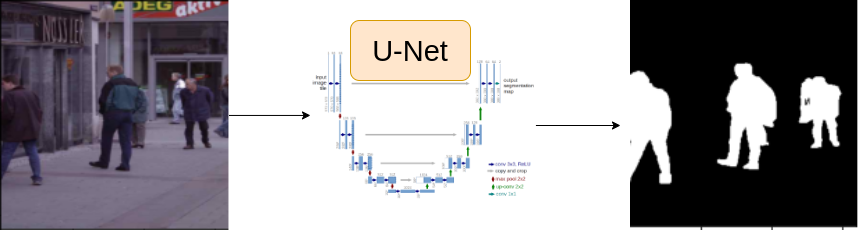

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
# get the first image at position 0 for visualization
row = df.iloc[0]

# use the .images attritute to get values and masks
image_path = row.images
mask_path = row.masks

# open cv2 to read the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

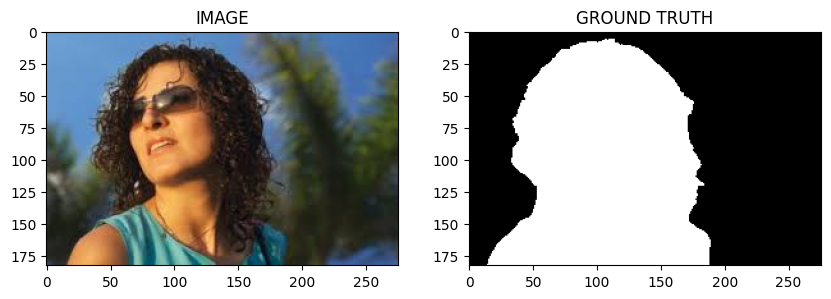

In [8]:
# Visualise the image and it ground truth
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(masks,cmap = 'gray');


In [9]:
# split the dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
# import library for augmentation
import albumentations as A

In [11]:
# function for training dataset augmentation
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])


# function for validation dataset augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  # the initial method for the dataframe and augmentation
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  # length of the dataframe
  def __len__(self):
    return len(self.df)

  # get item the image attributes
  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    data = self.augmentations(image=image, mask=mask)
    image = data['image']
    mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)


    # convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [14]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


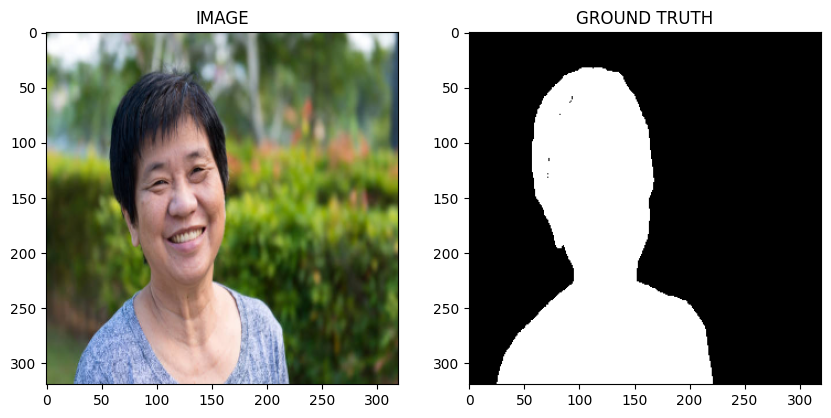

In [16]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [19]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [20]:
for image, mask in trainloader:
  break
print(f"Image shape : {image.shape}")
print(f"Mask shape : {mask.shape}")

Image shape : torch.Size([16, 3, 320, 320])
Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):

    logits = self.arc(images)

    if mask is not None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 41.6MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [26]:
def train_fn(model, dataloader, optimizer):
  model.train()
  train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    optimizer.step()
    train_loss += loss.item()

    total_loss = train_loss / len(dataloader)
  return total_loss

In [25]:
def eval_fn(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


SAVED-MODEL
EPOCH : 1 | Train Loss : 1.3583946466445922 | Valid Loss : 1.3011704683303833


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


EPOCH : 2 | Train Loss : 1.365455436706543 | Valid Loss : 1.3020880222320557


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


EPOCH : 3 | Train Loss : 1.361710294087728 | Valid Loss : 1.3282924890518188


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


EPOCH : 4 | Train Loss : 1.3616737286249796 | Valid Loss : 1.3353572487831116


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


EPOCH : 5 | Train Loss : 1.3564080953598023 | Valid Loss : 1.3390234410762787


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


EPOCH : 6 | Train Loss : 1.364775824546814 | Valid Loss : 1.3384727239608765


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


EPOCH : 7 | Train Loss : 1.3628644227981568 | Valid Loss : 1.339053064584732


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


EPOCH : 8 | Train Loss : 1.3609045267105102 | Valid Loss : 1.3378621339797974


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


EPOCH : 9 | Train Loss : 1.3588690996170043 | Valid Loss : 1.339546799659729


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


EPOCH : 10 | Train Loss : 1.3632448434829711 | Valid Loss : 1.3390105962753296


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


EPOCH : 11 | Train Loss : 1.3586283286412557 | Valid Loss : 1.3384238481521606


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


EPOCH : 12 | Train Loss : 1.363307523727417 | Valid Loss : 1.33989417552948


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


EPOCH : 13 | Train Loss : 1.3599575599034628 | Valid Loss : 1.3399832546710968


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


EPOCH : 14 | Train Loss : 1.3661624987920125 | Valid Loss : 1.3395127952098846


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


EPOCH : 15 | Train Loss : 1.3574814319610595 | Valid Loss : 1.3379236161708832


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


EPOCH : 16 | Train Loss : 1.362059203783671 | Valid Loss : 1.3384883999824524


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


EPOCH : 17 | Train Loss : 1.3675534963607787 | Valid Loss : 1.340160459280014


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


EPOCH : 18 | Train Loss : 1.3650272528330485 | Valid Loss : 1.3386745750904083


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


EPOCH : 19 | Train Loss : 1.3583039442698162 | Valid Loss : 1.3391753435134888


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


EPOCH : 20 | Train Loss : 1.3625771204630535 | Valid Loss : 1.339117020368576


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


EPOCH : 21 | Train Loss : 1.3600253899892172 | Valid Loss : 1.3396758139133453


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


EPOCH : 22 | Train Loss : 1.360259715716044 | Valid Loss : 1.3403531610965729


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


EPOCH : 23 | Train Loss : 1.363176735242208 | Valid Loss : 1.3376613855361938


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


EPOCH : 24 | Train Loss : 1.3566904544830323 | Valid Loss : 1.3394299149513245


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

EPOCH : 25 | Train Loss : 1.3638596455256145 | Valid Loss : 1.3414195477962494


# Task 9 : Inference

In [31]:
def inference(indx):
  idx = indx

  model.load_state_dict(torch.load('/content/best_model.pth'))

  image, mask = validset[idx]


  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

<ipython-input-29-4d9074086fc7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


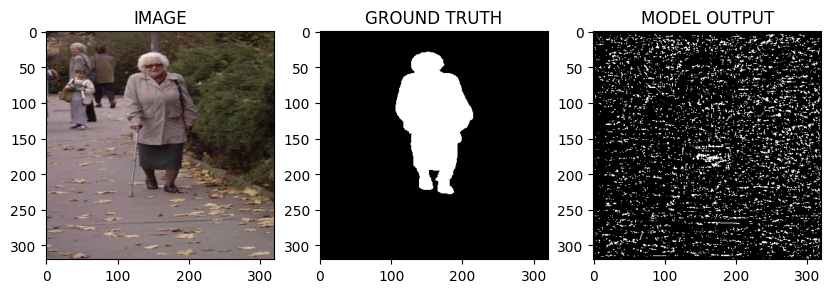

In [30]:
inference(5)